---

## Задание 1: Теоретическое описание задачи

Задача извлечения именованных сущностей (Named Entity Recognition, NER) — это ключевая подзадача обработки естественного языка (NLP), направленная на автоматическое обнаружение и классификацию сущностей в неструктурированном тексте. К типичным категориям сущностей относятся:

- `PER` — персоны (люди),
- `ORG` — организации,
- `LOC` — географические объекты,
- `EVT` — события,
- `PRO` — продукты или объекты.

**Классические методы:**
До распространения нейронных сетей основными подходами были:

- Правила и шаблоны (rule-based systems),
- Статистические модели: HMM (Hidden Markov Models), CRF (Conditional Random Fields),
- Feature engineering — ручное составление признаков на основе лингвистических свойств.

**Современные подходы (LLM):** 

С появлением больших языковых моделей (LLM) стало возможным извлечение сущностей в zero-shot или few-shot режимах, без дополнительного обучения. GigaChat, как представитель LLM, способен воспринимать структурированный prompt и возвращать списки сущностей, опираясь на контекст.

**Метрики качества:**

Для оценки качества предсказания применяются:

Precision (точность),
Recall (полнота),
F1-score — гармоническое среднее между precision и recall.
Оценка может проводиться:

По каждой сущности (class-wise),
В среднем (macro/micro-average).

---

##  Задание 2: Загрузка и подготовка датасета

**Формулировка:**  
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками:
- `document_id`
- `document_text`
- `entity`
- `gold_answer`

Выведите шапку датафрейма.


In [1]:
import sys, os
import pandas as pd


sys.path.insert(0, os.path.abspath('..'))

def load_annotations(annotation_dir: str) -> pd.DataFrame:
    records = []
    for fname in os.listdir(annotation_dir):
        if not fname.endswith('.out'):
            continue
        doc_id = os.path.splitext(fname)[0]
        with open(os.path.join(annotation_dir, fname), encoding='utf-8') as f:
            lines = [L.strip() for L in f if L.strip()]
        if lines and lines[0] == doc_id.split('_')[-1]:
            lines = lines[1:]
        for line in lines:
            parts = line.rsplit(None, 3)
            if len(parts) >= 4:
                surface, lemma, ent_type, canonical = parts
                records.append({
                    'document_id': doc_id,
                    'entity': ent_type,
                    'gold_answer': surface
                })
    return pd.DataFrame(records)

def load_texts(text_dir: str, skip_lines: int = 4) -> pd.DataFrame:
    records = []
    for fname in os.listdir(text_dir):
        if not fname.endswith('.txt'):
            continue
        doc_id = os.path.splitext(fname)[0]
        with open(os.path.join(text_dir, fname), encoding='utf-8') as f:
            lines = f.read().splitlines()
        body = "\n".join(lines[skip_lines:]).strip()
        records.append({
            'document_id': doc_id,
            'document_text': body
        })
    return pd.DataFrame(records)





from src.data_loader import load_annotations, load_texts



ANN_DIR = '../data/annotations'
TXT_DIR = '../data/raw'

df_ann = load_annotations(ANN_DIR)
df_txt = load_texts   (TXT_DIR)
df     = df_ann.merge(df_txt, on='document_id', how='left')
display(df.head())





,document_id,entity,gold_answer,document_text
0,brexit_ru.txt_file_10,EVT,Brexit,Тереза Мэй рассчитывает усидеть в седле до зав...
1,brexit_ru.txt_file_10,LOC,Альбиона,Тереза Мэй рассчитывает усидеть в седле до зав...
2,brexit_ru.txt_file_10,LOC,Альбионе,Тереза Мэй рассчитывает усидеть в седле до зав...
3,brexit_ru.txt_file_10,PER,Борис Джонсон Борис,Тереза Мэй рассчитывает усидеть в седле до зав...
4,brexit_ru.txt_file_10,LOC,Британии,Тереза Мэй рассчитывает усидеть в седле до зав...


---

##  Задание 3: Формирование prompt-функции для LLM

**Формулировка:**  
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM




In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))


import pandas as pd
from src.data_loader import load_annotations, load_texts


ANN_DIR = '../data/annotations'
TXT_DIR = '../data/raw'

df_ann = load_annotations(ANN_DIR)
df_txt = load_texts   (TXT_DIR)
df     = df_ann.merge(df_txt, on='document_id', how='left')


df.head()


,document_id,entity,gold_answer,document_text
0,brexit_ru.txt_file_10,EVT,Brexit,Тереза Мэй рассчитывает усидеть в седле до зав...
1,brexit_ru.txt_file_10,LOC,Альбиона,Тереза Мэй рассчитывает усидеть в седле до зав...
2,brexit_ru.txt_file_10,LOC,Альбионе,Тереза Мэй рассчитывает усидеть в седле до зав...
3,brexit_ru.txt_file_10,PER,Борис Джонсон Борис,Тереза Мэй рассчитывает усидеть в седле до зав...
4,brexit_ru.txt_file_10,LOC,Британии,Тереза Мэй рассчитывает усидеть в седле до зав...


In [3]:
from src.prompt import make_prompt


example = df.iloc[0]

prompt_text = make_prompt(
    example['document_id'],
    example['document_text'][:300] + '…',  
    example['entity']
)

print(prompt_text)



Документ «brexit_ru.txt_file_10»:

Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit

Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможног…

Пожалуйста, извлеки из этого текста все сущности типа «EVT» и верни их в виде списка (каждая сущность на новой строке).


---

##  Задание 4: Ручное получение ответов от GigaChat и сохранение

**Формулировка:**  
Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. 




In [4]:

from src.prompt import make_prompt

MAX_SNIPPET = 120


unique_ids = df['document_id'].unique()

for doc_id in unique_ids:
    print(f"--- PROMPT for {doc_id} ---")
    print(
        f"Я отправляю тебе файл с текстом (document_id: {doc_id}).\n"
        "Пожалуйста, прочитай его и извлеки из этого текста "
        "все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка "
        "(каждая сущность на новой строке).\n"
    )



--- PROMPT for brexit_ru.txt_file_10 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_10).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

--- PROMPT for brexit_ru.txt_file_1000 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1000).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

--- PROMPT for brexit_ru.txt_file_1001 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1001).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

--- PROMPT for brexit_ru.txt_file_1002 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1002).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, L

In [5]:


raw = """
--- PROMPT for brexit_ru.txt_file_10 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_10).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_10.txt
Ответ

PER:

Тереза Мэй
Борис Джонсон
Мишель Барнье
Себастьян Курц
LOC:

Великобритания
Северная Ирландия
Брюссель
Альбион
Ла-Манш
ORG:

партия тори
Международная валютный фонд
Еврокомиссия
Европейский парламент
Британский парламент
Лейбористы
Консерваторы
EVT:

процедура Brexit
конференция партии тори
переговоры по Brexit
экстренный саммит Евросоюза
выход из состава Евросоюза
утверждения сделки с Евросоюзом
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1000 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1000).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1000.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
Дэвид Дэвис
Стив Бейкер
LOC:

Великобритания
ЕС
ORG:

Министерство иностранных дел Великобритании
Кабинет министров Великобритании
Пресс-служба британского парламента
EVT:

уход с должности
переговоры с ЕС
Brexit
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1001 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1001).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1001.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
LOC:

Великобритания
Евросоюз (ЕС)
ORG:

Министерство иностранных дел Великобритании
Канцелярия премьер-министра
EVT:

подача в отставку
Brexit
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1002 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1002).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1002.txt
Ответ

PER:

Тереза Мэй
Борис Джонсон
Дэвид Дэвис
LOC:

Великобритания
Евросоюз (ЕС)
ORG:

Правительство Великобритании
Министерство иностранных дел Великобритании
Министр по делам «Брекзит»
EVT:

принятие отставки
Brexit
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1003 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1003).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1003.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
Давид Дэвис
LOC:

Великобритания
Евросоюз (ЕС)
ORG:

Министерство иностранных дел Великобритании
Правительственная резиденция на Даунинг-стрит
EVT:

уход с должности
Brexit
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1004 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1004).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1004.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
Давид Дэвис
LOC:

Великобритания
Евросоюз (ЕС)
Германия
Польша
Лондон
Западные Балканы
ORG:

МИД Великобритании
Консервативная партия
Канализация премьер-министра Великобритании
EVT:

подача в отставку
Brexit
пресс-конференция
Саммит по развитию региона Западных Балкан
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1006 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1006).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1006.txt
Ответ

PER:

Борис Джонсон
Мария Захарова
Тереза Мэй
LOC:

Великобритания
Россия
ORG:

МИД России
Правительство Великобритании
Facebook
EVT:

отставка
Brexit
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1011 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1011).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1011.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
Дэвид Дэвис
LOC:

Великобритания
ЕС
ORG:

Правительство Великобритании
Палата общин
The Guardian
EVT:

отставка
Brexit
формирование стратегии выхода из ЕС
PRO:

документ (текст)

--- PROMPT for brexit_ru.txt_file_1017 ---
Я отправляю тебе файл с текстом (document_id: brexit_ru.txt_file_1017).
Пожалуйста, прочитай его и извлеки из этого текста все сущности (типы PER, LOC, ORG, EVT, PRO) и верни их в виде списка (каждая сущность на новой строке).

brexit_ru.txt_file_1017.txt
Ответ

PER:

Борис Джонсон
Тереза Мэй
Давид Дэвис
Стив Бейкер
LOC:

Великобритания
Киев
ORG:

МИД Великобритании
Парламент Великобритании
Правительство Великобритании
The Guardian
УНН
EVT:

подача в отставку
Brexit
переговоры с ЕС
PRO:

документ (текст)
"""


import pandas as pd
import re

records = []

blocks = re.split(r"--- PROMPT for ([\w\.]+) ---", raw)[1:]  

for i in range(0, len(blocks), 2):
    doc_id = blocks[i]
    content = blocks[i+1]
    
    parts = content.split("Ответ",1)[-1]
    lines = [line.strip() for line in parts.splitlines() if line.strip()]
    current_type = None
    for line in lines:
        
        if re.match(r"^(PER|LOC|ORG|EVT|PRO):$", line):
            current_type = line[:-1]
        
        elif not re.match(r"^(PER|LOC|ORG|EVT|PRO):$", line):
            
            entity = line.lstrip("•").strip()
            if current_type:
                records.append({
                    "document_id": doc_id,
                    "entity_type": current_type,
                    "predicted": entity
                })


df_pred = pd.DataFrame(records)


output_path = '../data/predictions/predictions.csv'
df_pred.to_csv(output_path, index=False, encoding='utf-8-sig')

df_pred.head()


from src.data_loader import load_annotations
import pandas as pd

ANN_DIR = "../data/annotations"

df_gold = load_annotations(ANN_DIR)
df_gold.to_csv("../data/annotations/gold.csv", index=False, encoding="utf-8-sig")
df_gold.head()


,document_id,entity,gold_answer
0,brexit_ru.txt_file_10,EVT,Brexit
1,brexit_ru.txt_file_10,LOC,Альбиона
2,brexit_ru.txt_file_10,LOC,Альбионе
3,brexit_ru.txt_file_10,PER,Борис Джонсон Борис
4,brexit_ru.txt_file_10,LOC,Британии


---

##  Задание 5: Реализация метрики score_fn() и юнит-тесты

**Формулировка:**  
<Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float.>




In [6]:

import pandas as pd
from src.metrics import score_fn          

df_gold = pd.read_csv("../data/annotations/gold.csv", encoding="utf-8-sig")
df_pred = pd.read_csv("../data/predictions/predictions.csv", encoding="utf-8-sig")


df = (
    df_pred
    .rename(columns={"entity_type": "entity"})
    .merge(df_gold, on=["document_id","entity"], how="left")
)


df["gold_answer"] = df["gold_answer"].fillna("")
df["predicted"]   = df["predicted"].fillna("")

# 3) считаем F1
df["f1"] = df.apply(
    lambda row: score_fn(row["gold_answer"], row["predicted"]),
    axis=1,
)


df.head()






,document_id,entity,predicted,gold_answer,f1
0,brexit_ru.txt_file_10,PER,Тереза Мэй,Борис Джонсон Борис,0.000000
1,brexit_ru.txt_file_10,PER,Тереза Мэй,Джонсон,0.000000
2,brexit_ru.txt_file_10,PER,Тереза Мэй,Джонсона,0.000000
3,brexit_ru.txt_file_10,PER,Тереза Мэй,Мишелю Барнье Мишель,0.000000
4,brexit_ru.txt_file_10,PER,Тереза Мэй,Мэй,0.666667


## 1. **Векторная реализация**

- В текущей реализации мы вызываем score_fn для каждой строки через DataFrame.apply, что на больших объёмах может быть медленно. Для ускорения можно:

- Преобразовать все gold строки и все pred строки в списки токенов заранее (например, с помощью .str.split()) и сложить их в два массива списков.

- Для каждого элемента массива вычислять пересечение множеств с помощью NumPy или SciPy векторных операций:

- Можно представить каждое множество токенов как мешок слов  и получить из этого разреженные матрицы csr_matrix из scipy.sparse.

 Тогда попарную точность и полноту можно высчитать через матричное умножение этих разреженных матриц, а F1 — уже от полученных векторов precision/recall.

Либо использовать sklearn.feature_extraction.text.CountVectorizer + sklearn.metrics.precision_recall_fscore_support, чтобы сразу получить векторные оценки по всем строкам.

- Такой подход позволяет уйти от поэлементного Python‑цикла и задействовать оптимизации на C/C++ внутри NumPy/SciPy.

## 2. **Почему F1‑метрика**
Мы выбрали именно F1‑меру (­гармоническое среднее precision и recall), потому что:

- Precision показывает, какой процент предсказанных токенов действительно встречается в правильном ответе (он же «точность»).

- Recall показывает, какой процент «золотых» токенов был найден (он же «полнота»).

- F1 объединяет оба аспекта в одну скалярную метрику и не позволяет «завалить» качество одним из параметров:

- Если модель просто выдаёт всё подряд, у неё будет высокий recall, но низкий precision → низкий F1.

- Если модель слишком консервативна, precision будет высоким, но recall — низким → опять низкий F1.

Таким образом F1 отражает баланс между переизбыточностью и неполнотой предсказаний, что критично для задачи извлечения сущностей (где важно и не пропустить ни одной нужной сущности, и не наплодить лишнего).

---

##  Задание 6: Расчёт метрик и визуализация по сущностям/документам

**Формулировка:**  
<сюда можно вставить формулировку из ТЗ>



entity
PER    0.147079
EVT    0.120915
ORG    0.035698
LOC    0.010769
PRO    0.000000
Name: f1, dtype: float64


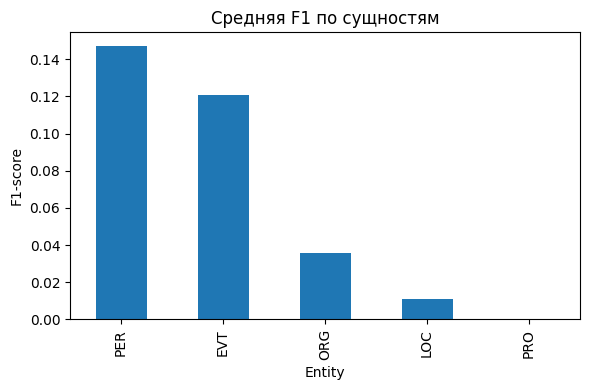

document_id
brexit_ru.txt_file_1006    0.162745
brexit_ru.txt_file_1001    0.135632
brexit_ru.txt_file_1011    0.121333
brexit_ru.txt_file_1000    0.119697
brexit_ru.txt_file_1017    0.111861
brexit_ru.txt_file_1003    0.102564
brexit_ru.txt_file_1002    0.080000
brexit_ru.txt_file_1004    0.045977
brexit_ru.txt_file_10      0.035903
Name: f1, dtype: float64


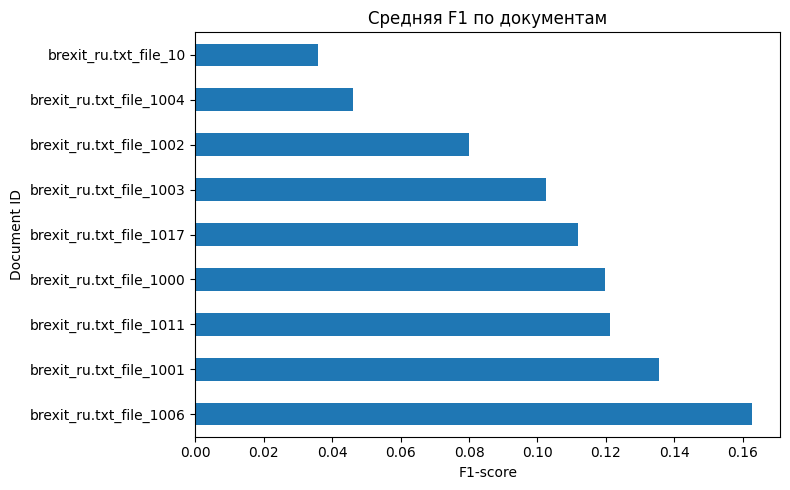

In [7]:
# импортируем matplotlib
import matplotlib.pyplot as plt

# группа по типу сущности, усредняем F1
entity_scores = df.groupby("entity")["f1"].mean().sort_values(ascending=False)

# выводим на экран
print(entity_scores)

# строим столбчатую диаграмму
plt.figure(figsize=(6,4))
entity_scores.plot(kind="bar")
plt.title("Средняя F1 по сущностям")
plt.ylabel("F1-score")
plt.xlabel("Entity")
plt.tight_layout()
plt.show()

# группа по документу, усредняем F1
doc_scores = df.groupby("document_id")["f1"].mean().sort_values(ascending=False)

print(doc_scores)

# строим график (горизонтальная бочка лучше для длинных названий)
plt.figure(figsize=(8,5))
doc_scores.plot(kind="barh")
plt.title("Средняя F1 по документам")
plt.xlabel("F1-score")
plt.ylabel("Document ID")
plt.tight_layout()
plt.show()


### Выводы по заданию 6

1. **Средняя F1 по сущностям**  
   - Лучше всего модель отвечает на персоны (PER) и события (EVT) – их средняя F1 ≈0.15 и 0.12 соответственно.  
   - Худшие результаты по продуктам (PRO, F1=0) и географическим объектам (LOC, F1≈0.01).  

2. **Средняя F1 по документам** 
   - Самые высокие F1‑значения у документов brexit_ru.txt_file_1006 (~0.16) и brexit_ru.txt_file_1001 (~0.14).  
   - Худший – `brexit_ru.txt_file_10` (≈0.035).  

3. **Что это означает**  
   - ГигаЧат лучше извлекает «людские» и «событийные» сущности, хуже – короткие/неоднозначные названия локаций и технические термины (PRO).  
   - Качество распознавания сильно варьируется от документа к документу — возможно, из‑за разного стиля и плотности сущностей в тексте.  
   - Для повышения метрик стоит либо улучшить prompt (добавить контекст), либо пост‑обрабатывать ответы (к примеру, нормализация форм имен и фильтрация шумовых токенов).



---

##  Задание 7: Анализ зависимости качества от длины документа

**Формулировка:**  
<сюда можно вставить формулировку из ТЗ>


In [8]:
# Код для задания 7

---

##  Задание 8: Анализ ошибок, слабых и сильных сторон модели

**Формулировка:**  




In [9]:
# Код для задания 8

---

##  Задание 9: Выводы по проекту и самооценка

**Формулировка:**  





In [10]:
# Код для задания 9